# DO NOT EDIT!
Instead edit the notebook in `ctapipe_io_nectarcam/notebooks/test_trigger_patches.ipynb` then create this file with
```
jupytext ../../../notebooks/test_trigger_patches.ipynb -o ./test_trigger_patches.py
```

In [1]:
def make_new_cameras(camera_type=0,display=False):
    import numpy as np
    from matplotlib import pyplot as plt
    from astropy import units as u
    
    #Make a camera with modified Descartes spacing
    radius = 0.5
    x_space = radius
    y_space = x_space*np.sin(60*u.deg)
    
    layout = [ [-1,0],[-1,1],
           [0,-1],[0,0],[0,1],
              [1,0],[1,1]]
    
    
    module = []
    for row in layout:
        if row[0]%2 == 0:
            module.append([row[1]*x_space,row[0]*y_space])
        else:
            module.append([row[1]*x_space-x_space/2,row[0]*y_space])
    module = np.array(module)
    
    if display:
        plt.figure(figsize=(5,5))
        plt.xlim((-4,6))
        plt.ylim((-4,6))
        plt.grid()
    
    pixels0 = np.concatenate((module,
                             module+np.array([x_space*5/2,y_space]),
                             module+np.array([x_space/2,3*y_space]),
                             module+np.array([-x_space*2,y_space*2]),
                             module+np.array([-x_space*5/2,-y_space]),
                             module+np.array([-x_space/2,-3*y_space]),
                             module+np.array([x_space*2,-2*y_space]),
                            ))
    pixels = pixels0
    
    if display:
        plt.plot(pixels[:,0],pixels[:,1],'o')

    if camera_type==0:
        if display:
            plt.show()
        return pixels,radius,"Good Example, 7 modules"

    pixels1 = np.concatenate((module+np.array([x_space*9/2,-y_space*2/2]),
                             module+np.array([x_space*10/2,y_space*4/2]),
                             module+np.array([x_space*6/2,y_space*8/2]),                         
                             ))
    
    pixels = pixels1

    if display:
        plt.plot(pixels[:,0],pixels[:,1],'x')
    
    pixels = np.concatenate((pixels0,pixels1))
    
    #plt.plot(module.T,'x')

    if camera_type==1:
        if display:
            plt.show()
        return pixels,radius,"Good Example, 10 modules"

    ten_modules = pixels
    # Remove 3 pixels, should raise ValueError for not multiple of 7
    pixels = pixels[:-3, :]
    if camera_type==2:
        if display:
            plt.show()
        return pixels,radius,"Bad Example, 10 modules - 3 pixels"

    pixels = ten_modules
    pix_mid_module = [3, 10, 17, 24, 31, 38, 45, 52, 59, 66]
    pixels = np.delete(pixels, pix_mid_module[:7], axis=0)
    if camera_type==3:
        if display:
            plt.show()
        return pixels,radius,"Bad Example, 10 modules - missing 7 central pixels"
    
    pixels = ten_modules
    edge_pix = [50, 53, 57, 60, 62, 68, 69]
    pixels = np.delete(pixels, edge_pix, axis=0)
    if camera_type==4:
        if display:
            plt.show()
        return pixels,radius,"Vicious Example, 10 modules - missing 7 edge pixels"
    
    # Now do the case for other types
    return pixels,radius,"Final example camera"


In [2]:
def test_trigger_patches_simple_camera():
    import numpy as np
    from astropy import units as u
    from astropy import table
    from ctapipe_io_nectarcam import find_central_pixels,nectar_trigger_patches
    from ctapipe.instrument.camera.geometry import CameraGeometry
    
    pixels,radius,camera_name = make_new_cameras(0,False)

    n_pix = len(pixels)
    pix_x=pixels[:,0]*u.cm
    pix_y=pixels[:,1]*u.cm

    # In future, shouldn't need to do this.
    pix_area = np.array([np.pi*radius**2]*n_pix)*u.cm**2    

    geom_new = CameraGeometry(camera_name,
                              pix_x=pix_x,pix_y=pix_y,
                              pix_id=table.column.Column(range(n_pix)),
                              pix_area=pix_area,
                              pix_type="hexagon")
    
    pix_mid_module = find_central_pixels(geom_new)
    assert pix_mid_module == [3, 10, 17, 24, 31, 38, 45]

    trigger_patches = nectar_trigger_patches(geom_new,
                                             pix_mid_module)

    assert trigger_patches == [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 21, 22, 24, 
                                25, 27, 29, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48], 
                               [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 44, 45, 46, 47, 48], 
                               [2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27], 
                               [0, 2, 3, 5, 6, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34], 
                               [0, 1, 2, 3, 5, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41], 
                               [0, 1, 2, 3, 4, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47], 
                               [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]]


In [3]:
def test_trigger_patches_bigger_camera():
    import numpy as np
    from astropy import units as u
    from astropy import table
    from ctapipe_io_nectarcam import find_central_pixels,nectar_trigger_patches
    from ctapipe.instrument.camera.geometry import CameraGeometry
    
    pixels,radius,camera_name = make_new_cameras(1,False)

    n_pix = len(pixels)
    pix_x=pixels[:,0]*u.cm
    pix_y=pixels[:,1]*u.cm

    # In future, shouldn't need to do this.
    pix_area = np.array([np.pi*radius**2]*n_pix)*u.cm**2    

    geom_new = CameraGeometry(camera_name,
                              pix_x=pix_x,pix_y=pix_y,
                              pix_id=table.column.Column(range(n_pix)),
                              pix_area=pix_area,
                              pix_type="hexagon")
    
    pix_mid_module = find_central_pixels(geom_new)
    assert pix_mid_module ==  [3, 10, 17, 24, 31, 38, 45, 52, 59, 66]

    trigger_patches = nectar_trigger_patches(geom_new,
                                             pix_mid_module)

    assert trigger_patches == [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 21, 22, 24, 
                                25, 27,29, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48], 
                               [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 44, 45, 
                                46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 61, 63, 64, 65, 66, 67], 
                               [2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 63, 64, 65, 66, 68], 
                               [0, 2, 3, 5, 6, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34], 
                               [0, 1, 2, 3, 5, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41], 
                               [0, 1, 2, 3, 4, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47], 
                               [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54], 
                               [7, 8, 10, 11, 13, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60], 
                               [8, 10, 11, 12, 13, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 69], 
                               [9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 56, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69]]


In [4]:
def test_trigger_patches_10modules_minus_3pixels_camera_ValueError():
    import pytest
    import numpy as np
    from astropy import units as u
    from astropy import table
    from ctapipe_io_nectarcam import find_central_pixels,nectar_trigger_patches
    from ctapipe.instrument.camera.geometry import CameraGeometry
    
    pixels,radius,camera_name = make_new_cameras(2,False)

    n_pix = len(pixels)
    pix_x=pixels[:,0]*u.cm
    pix_y=pixels[:,1]*u.cm

    # In future, shouldn't need to do this.
    pix_area = np.array([np.pi*radius**2]*n_pix)*u.cm**2    

    geom_new = CameraGeometry(camera_name,
                              pix_x=pix_x,pix_y=pix_y,
                              pix_id=table.column.Column(range(n_pix)),
                              pix_area=pix_area,
                              pix_type="hexagon")
    
    with pytest.raises(Exception):
        pix_mid_module = find_central_pixels(geom_new)

In [5]:
def test_trigger_patches_10modules_minus_7_central_pixels_ValueError():
    import pytest
    import numpy as np
    from astropy import units as u
    from astropy import table
    from ctapipe_io_nectarcam import find_central_pixels,nectar_trigger_patches
    from ctapipe.instrument.camera.geometry import CameraGeometry
    
    pixels,radius,camera_name = make_new_cameras(3,False)

    n_pix = len(pixels)
    pix_x=pixels[:,0]*u.cm
    pix_y=pixels[:,1]*u.cm

    # In future, shouldn't need to do this.
    pix_area = np.array([np.pi*radius**2]*n_pix)*u.cm**2    

    geom_new = CameraGeometry(camera_name,
                              pix_x=pix_x,pix_y=pix_y,
                              pix_id=table.column.Column(range(n_pix)),
                              pix_area=pix_area,
                              pix_type="hexagon")
    
    with pytest.raises(Exception):
        pix_mid_module = find_central_pixels(geom_new)

In [6]:
def test_trigger_patches_10modules_minus_7_edge_pixels_ValueError():
    import pytest
    import numpy as np
    from astropy import units as u
    from astropy import table
    from ctapipe_io_nectarcam import find_central_pixels,nectar_trigger_patches
    from ctapipe.instrument.camera.geometry import CameraGeometry
    
    pixels,radius,camera_name = make_new_cameras(4,False)

    n_pix = len(pixels)
    pix_x=pixels[:,0]*u.cm
    pix_y=pixels[:,1]*u.cm

    # In future, shouldn't need to do this.
    pix_area = np.array([np.pi*radius**2]*n_pix)*u.cm**2    

    geom_new = CameraGeometry(camera_name,
                              pix_x=pix_x,pix_y=pix_y,
                              pix_id=table.column.Column(range(n_pix)),
                              pix_area=pix_area,
                              pix_type="hexagon")
    
    with pytest.raises(Exception):
        pix_mid_module = find_central_pixels(geom_new)

In [7]:
# Below for testing by hand

/scr/punch/miniconda3/envs/new-nectar-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Central Pixels: [ 3 10 17 24 31 38 45 52 59 66]
10 70
[ 3 10 17 24 31 38 45 52 59 66]


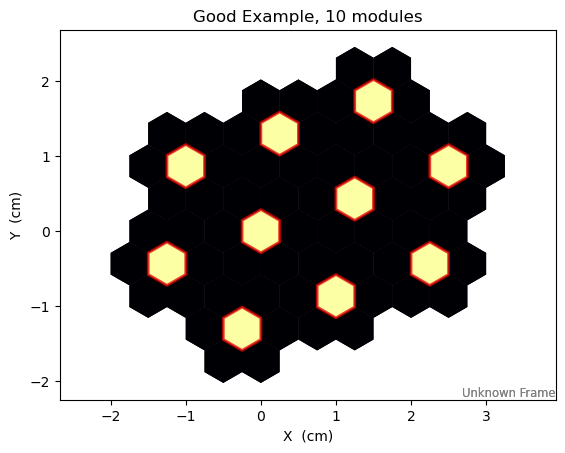

Trigger patches: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 21, 22, 24, 25, 27, 29, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48], [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 61, 63, 64, 65, 66, 67], [2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 63, 64, 65, 66, 68], [0, 2, 3, 5, 6, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34], [0, 1, 2, 3, 5, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41], [0, 1, 2, 3, 4, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47], [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54], [7, 8, 10, 11, 13, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [8, 10, 11, 12, 13, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 69], [9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 56, 58, 59, 61, 62, 63,

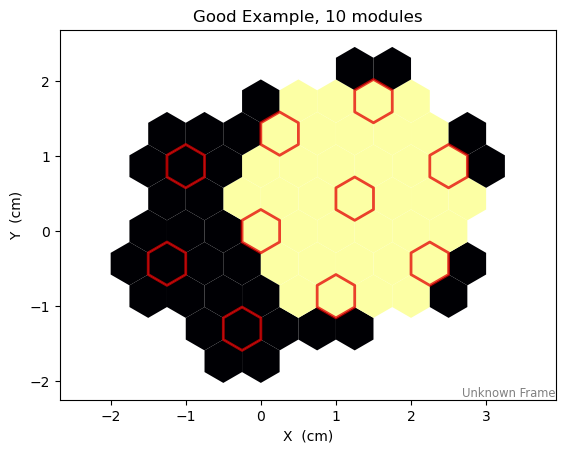

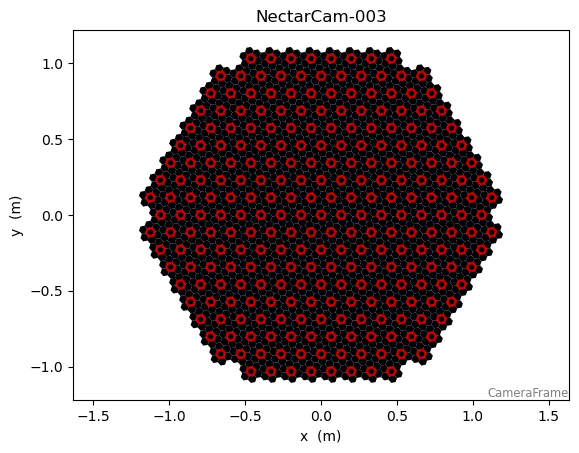

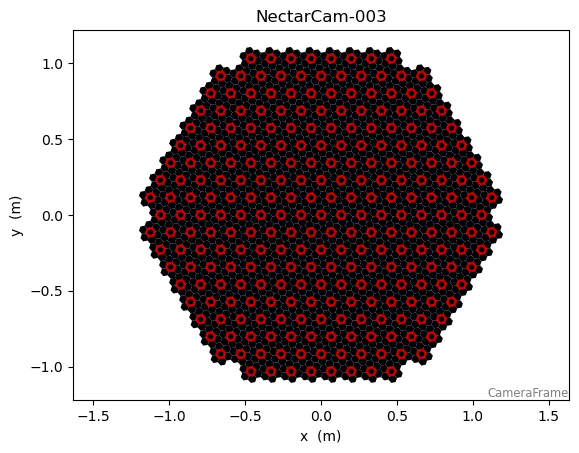

In [8]:
if __name__ == "__main__":
    import numpy as np
    from matplotlib import pyplot as plt
    from astropy import units as u
    from astropy import table

    # Load my functions for test (these are in __init__.py)
    from ctapipe_io_nectarcam import find_central_pixels,nectar_trigger_patches,module_central
    #from ctapipe_io_nectarcam import load_camera_geometry
    #geom = load_camera_geometry()

    new_camera_type = 0
    new_camera_type = 1
    
    pixels,radius,new_camera_name = make_new_cameras(new_camera_type,False)

    n_pix = len(pixels)
    pix_x=pixels[:,0]*u.cm
    pix_y=pixels[:,1]*u.cm
    
    from ctapipe.instrument.camera.geometry import CameraGeometry

    # In future, shouldn't need to do this.
    pix_area = np.array([np.pi*radius**2]*n_pix)*u.cm**2    
   
    geom_new = CameraGeometry(new_camera_name,
                              pix_x=pix_x,pix_y=pix_y,
                              pix_id=table.column.Column(range(n_pix)),
                              pix_area=pix_area,
                              pix_type="hexagon")
    
    from ctapipe.visualization import CameraDisplay
    
    # In future, shouldn't need to do this.
    geom_new.pixel_width = np.array([radius]*n_pix)*u.cm    
    
    CameraDisplay(geom_new)
    
    
    pix_mid_module = find_central_pixels(geom_new)
    print("Central Pixels:",pix_mid_module)
    print(len(pix_mid_module),len(pix_mid_module)*7)
    
    print(np.array(pix_mid_module))
    
    disp = CameraDisplay(geom_new)
    im = np.zeros(geom_new.n_pixels)
    
    disp.highlight_pixels(pix_mid_module, linewidth=2, color="xkcd:red")
    im[pix_mid_module] = 1
    disp.image = im
    #disp.add_colorbar()
    plt.show()

    trigger_patches = nectar_trigger_patches(geom_new,
                                             pix_mid_module)
    print("Trigger patches:",trigger_patches)
    print("Pixels in patches:",end=" ")
    for patch in trigger_patches:
        print(len(patch),end=", ")
    print()
    disp = CameraDisplay(geom_new)
    im = np.zeros(geom_new.n_pixels)
    im[trigger_patches[1]] = 2
    disp.image = im
    disp.highlight_pixels(pix_mid_module, linewidth=2, color="xkcd:red")
    #disp.add_colorbar()
    plt.show()

    from ctapipe_io_nectarcam import load_camera_geometry
    geom = load_camera_geometry()
    
    
    from ctapipe_io_nectarcam import find_central_pixels
        
    pix_mid_module = module_central(geom)
    disp = CameraDisplay(geom)
    im = np.zeros(geom.n_pixels)
    disp.image = im
    disp.highlight_pixels(pix_mid_module, linewidth=2, color="xkcd:red")
    plt.show()
    
    
    pix_mid_module = find_central_pixels(geom)
    disp = CameraDisplay(geom)
    im = np.zeros(geom.n_pixels)
    disp.image = im
    disp.highlight_pixels(pix_mid_module, linewidth=2, color="xkcd:red")
    plt.show()


In [9]:
    from ctapipe_io_nectarcam import load_camera_geometry
    geom = load_camera_geometry()
    
    
    from ctapipe_io_nectarcam import find_central_pixels
        

In [14]:
%%timeit -n 10
pix_mid_module = module_central(geom)

231 ms ± 6.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


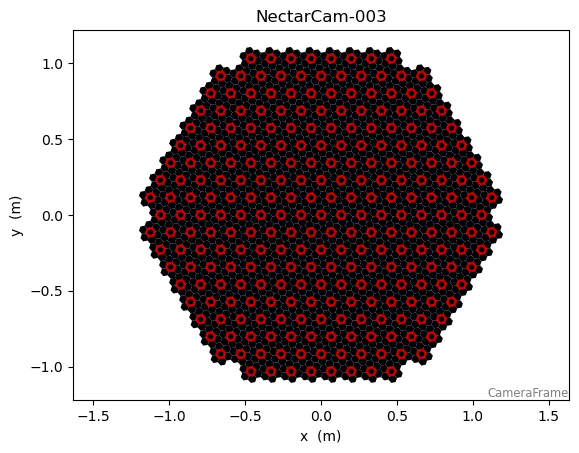

In [15]:
    disp = CameraDisplay(geom)
    im = np.zeros(geom.n_pixels)
    disp.image = im
    disp.highlight_pixels(pix_mid_module, linewidth=2, color="xkcd:red")
    plt.show()
    
    

In [16]:
%%timeit -n 10
pix_mid_module = find_central_pixels(geom)

14.6 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


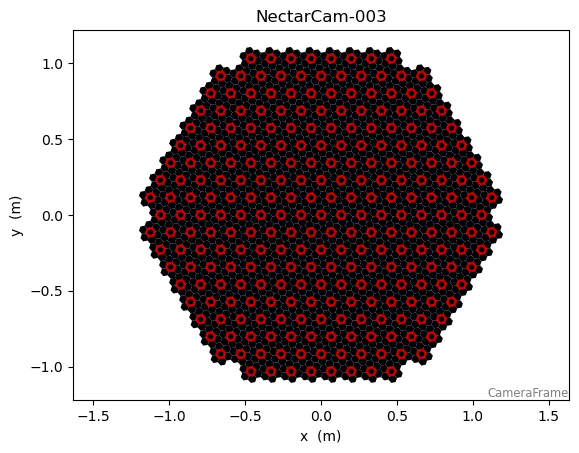

In [18]:
    disp = CameraDisplay(geom)
    im = np.zeros(geom.n_pixels)
    disp.image = im
    disp.highlight_pixels(pix_mid_module, linewidth=2, color="xkcd:red")
    plt.show()